In [42]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

In [43]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [3]:
import climpred

In [4]:
dpath = pathlib.Path('/media/nicolasf/END19101/data/climate_indices')

In [54]:
indice_name = 'M1'

In [5]:
# SAM_obs = pd.read_csv(dpath.joinpath("SAM_ERA5/SAM_ERA5.csv"), index_col=0, parse_dates=True) 

In [66]:
ind_obs = pd.read_csv(dpath.joinpath(f"{indice_name}_ERA5/{indice_name}_ERA5.csv"), index_col=0, parse_dates=True) 

In [67]:
ind_obs = ind_obs.to_xarray()

In [56]:
ind_ecmwf = pd.read_csv(dpath.joinpath(f"{indice_name}_GCM/{indice_name}_ECMWF.csv"), index_col=0, parse_dates=True, header=[0,1]) 

In [57]:
ind_ecmwf.head()

M1                                                  
                   0         1         2         3         4         5
init_time                                                             
1981-01-01 -0.123254 -0.172892 -1.080335 -1.058909 -0.239231  0.778716
1981-02-01 -0.653366 -0.694484  0.089498 -0.187936  1.376427  0.730591
1981-03-01 -1.819176 -1.294167  0.306167 -0.976364 -0.858239 -0.015927
1981-04-01 -1.385673  0.328970  1.262338  0.603248 -0.615654 -0.922839
1981-05-01 -0.714190  0.201029 -1.036761  1.005477  0.132990 -0.690568

In [58]:
ind_ecmwf_xr = {}

In [59]:
ind_ecmwf_xr['init'] = (('init'), ind_ecmwf.index.to_pydatetime()) 

In [60]:
ind_ecmwf_xr['lead'] = (('lead'), np.arange(6))

In [61]:
ind_ecmwf_xr[indice_name] = (('init','lead'), ind_ecmwf.values)

In [62]:
ind_ecmwf_xr = xr.Dataset(ind_ecmwf_xr) 

In [63]:
ind_ecmwf_xr['lead'].attrs = {'units':'months'}

In [64]:
hindcast = climpred.HindcastEnsemble(ind_ecmwf_xr)

In [68]:
hindcast = hindcast.add_observations(ind_obs)

In [69]:
acc = hindcast.verify(metric='pearson_r', comparison='e2o', dim='init', alignment='maximize', reference='persistence')

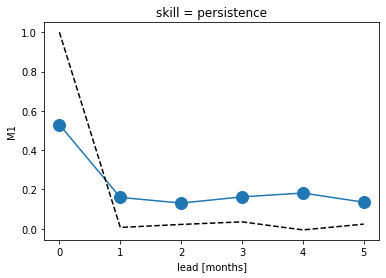

In [73]:
acc.sel(skill='initialized')[indice_name].plot(marker='o', markersize=12)
acc.sel(skill='persistence')[indice_name].plot(color='k', linestyle='--')

In [74]:
result = []
for label, group in ind_ecmwf_xr.groupby('init.month'):
    hindcast = climpred.HindcastEnsemble(group)
    hindcast = hindcast.add_observations(ind_obs)
    hindcast.load()
    skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')
    result.append(skill)

result = xr.concat(result, dim='month')
result['month'] = np.arange(12) + 1

In [75]:
result

<xarray.Dataset>
Dimensions:  (lead: 6, month: 12)
Coordinates:
  * lead     (lead) int64 0 1 2 3 4 5
    skill    <U11 'initialized'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    M1       (month, lead) float64 0.6323 -0.0342 0.1717 ... -0.1067 -0.1552

In [76]:
result = result.to_dataframe()[indice_name].unstack()

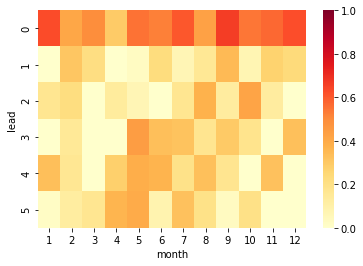

In [77]:
ax = sns.heatmap(result, cmap='YlOrRd', vmin=0, vmax=1)